In [896]:
from pandas import Series
import pandas as pd
import numpy as np

import math 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_confusion_matrix

In [897]:
df = pd.read_csv("./sf-dst-scoring/train.csv", low_memory = False)

In [898]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [899]:
df.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [900]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


We will not use application date information so let's drop this feature

In [901]:
df.drop('app_date', axis=1, inplace=True)

We have 307 missing values in 'education' field.
Let's fill them with the most frequent value.

In [902]:
df.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [903]:
df.education.fillna(value=df.education.value_counts().index[0], inplace=True)

Sorting the future model features by type (we skip Income and Education features as they will be processed separately)

In [904]:
num_cols = ['bki_request_cnt','decline_app_cnt','age','score_bki']      # numerical values -> standartize
bin_cols = ['sex','car','car_type','foreign_passport','good_work']      # binary values -> labelEncoder
cat_cols = ['home_address','work_address','region_rating','sna','first_time']   # categorical values -> OneHot encoder

- for binary features we will use LabelEncoder

In [905]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

- create dummy features for education

In [906]:
data_category = pd.get_dummies(df.education, drop_first=True)
data_category.head(5)

,GRD,PGR,SCH,UGR
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,1,0,0,0


replacing Education feature with dummy variables in the dataset

In [907]:
df.drop('education', axis=1, inplace=True)
df = pd.concat([df, data_category], axis=1)
df.head(2)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,work_address,income,sna,first_time,foreign_passport,default,GRD,PGR,SCH,UGR
0,25905,1,62,1,1,0,0,-2.008753,1,50,...,2,18000,4,1,0,0,0,0,1,0
1,63161,0,59,0,0,0,0,-1.532276,3,50,...,3,19000,4,1,0,0,0,0,1,0


In [908]:
edu_cols = ['GRD','PGR','SCH','UGR']

- check the distribution and correlation of numeric values

To evaluate the predictive value of numeric values we will use Weight of evidence (WoE) and Information Value (IV).

In [909]:
def WoE(target, feature, nbuck=10):
    """WoE (weight of evidence). The function draws WoE from feature average value in a bucket"""
    
    #Copying df
    df = pd.DataFrame()
    df['target']  = target.copy()
    df['feature'] = feature.copy()
    
    #Getting bucket number
    df['feature_buck'] = df['feature'].rank(method='min', pct=1, na_option = 'top').apply(
        lambda x: int((x- 1/df.shape[0])*nbuck))
    
    #Getting average value of target and observations count
    tr  = df['target'].mean()
    cnt = df['target'].count()
    
    #Aggregating by bucket
    df = df.groupby('feature_buck')['target' ].agg(tr='mean',cnt='size').join(
        df.groupby('feature_buck')['feature'].agg(feature_av='mean'))
    
    #Smoothing border values of tr 
    df.tr = df.tr.apply(lambda x: max(0.001, min(0.999, x)))
    
    #calculating WoE
    df.eval('WoE = log(tr/@tr)-log((1-tr)/(1-@tr))', inplace=True)
    
    #WoE error
    df.eval('WoE_d = 2/sqrt(tr*(1-tr)*cnt)', inplace=True) 
    
    #drop empty values
    df.dropna(inplace=True)
    
    #drawing
    fig = plt.gcf()
    plt.grid(True)
    plt.errorbar(df['feature_av'], df.WoE, yerr=np.array((df['WoE_d'])))
    plt.xlabel('feature')
    plt.ylabel('WoE')
    plt.show()

def IV(target, feature, nbuck=10):
    """IV (Information Value). Function returns IV of feature and target"""
    
    #Copying data
    df = pd.DataFrame()
    df['target']  = target.copy()
    df['feature'] = feature.copy()
    
    #Calculating bucket number
    df['feature_buck'] = df['feature'].rank(method='min', pct=1, na_option = 'top').apply(
        lambda x: int((x- 1.0/df.shape[0])*nbuck))
    
    #Getting average value of target and observations count
    tr  = df['target'].mean()
    cnt = df['target'].count()
    
    #Aggregating by bucket
    df = df.groupby('feature_buck')['target'].agg(tr='mean',cnt='size')
    
    #Smoothing border values of tr 
    df.tr = df.tr.apply(lambda x: max(0.001, min(0.999, x)))
    
    #Calculating IV
    df.eval('IV = ( (tr/@tr) - ((1-tr)/(1-@tr))) * (log(tr/@tr) - log((1-tr)/(1-@tr)) ) * (cnt/@cnt)', inplace=True)
    IV = df.IV.sum()
    
    return IV

Check score_bki feature

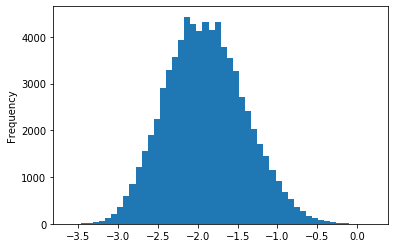

In [910]:
df.score_bki.plot.hist(bins=50);

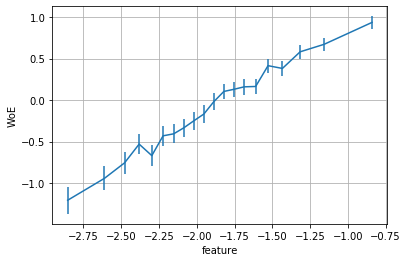

In [911]:
WoE(df.default, df.score_bki, nbuck=20)

In [912]:
IV(df.default, df.score_bki, nbuck=20)

0.2847601069800197

WoE monotonously grows with increase of score_bki value which makes it very well suitable for prediction, nothing to modify with this feature.

Checking income feature.

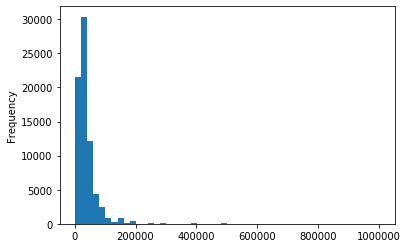

In [913]:
df.income.plot.hist(bins=50);

distribution indicates a heavy right tail

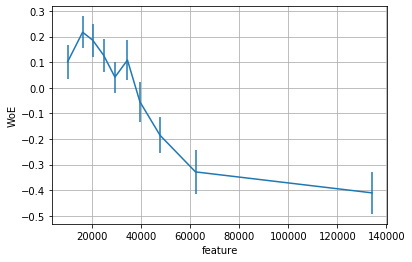

In [914]:
WoE(df.default, df.income, nbuck=10)

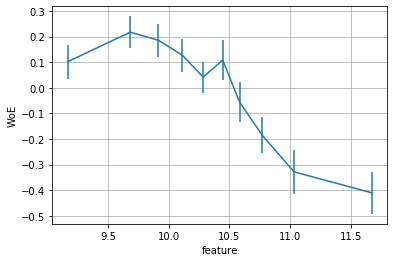

In [915]:
WoE(df.default, df.income.apply(lambda x: np.log(x)), nbuck=10)

The larger the income the fewer is the samples number in the dataset and WoE's shape does not look adequate. We need to modify income feature.

Let's check IV also for log(income)

In [916]:
print (IV(df.default, df.income, nbuck=10))
print (IV(df.default, df.income.apply(lambda x: np.log(x)), nbuck=10))
print (IV(df.default, df.income.apply(lambda x: int(x > 40000)), nbuck=10))

0.03974418386501799
0.03974418386501799
0.032424266238532486


Predictive power of income feature shows weak. The information value of alternative flag feature (income > 40000) is about the same as of original income feature so we can replace income variable with flag

In [917]:
df['income_more_40k'] = df.income.apply(lambda x: int(x > 40000))
df.drop('income', axis=1, inplace=True)

numerical values correlation check

result: check OK, correlation is low

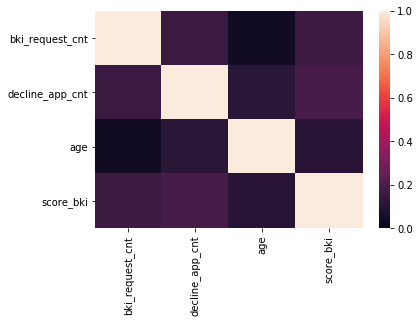

In [918]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

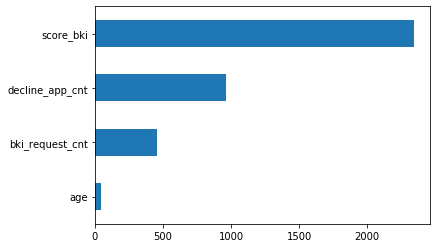

In [919]:
# finding most important feature with f_classif (f statistics probability)
# the larger is f_classif the more valuable the feature is for the model

imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

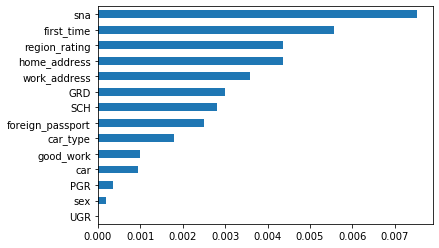

In [920]:
# To see the importance of categorical and binary features we will use mutual_info_classif from sklearn

imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols + edu_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols + edu_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

We can frop UGR dummy variable as it has no predictive value.

In [921]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   sex               73799 non-null  int32  
 2   age               73799 non-null  int64  
 3   car               73799 non-null  int32  
 4   car_type          73799 non-null  int32  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  int64  
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  sna               73799 non-null  int64  
 13  first_time        73799 non-null  int64  
 14  foreign_passport  73799 non-null  int32  
 15  default           73799 non-null  int64  
 16  GRD               73799 non-null  uint8 

In [922]:
# The final list of features to be used in the model

num_cols = ['bki_request_cnt','decline_app_cnt','score_bki','age']      # numerical values -> standartize
bin_cols = ['sex','car','car_type','foreign_passport','good_work','income_more_40k']
cat_cols = ['home_address','work_address','region_rating','sna','first_time']   # categorical values -> one hot encoder
edu_cols = ['GRD','SCH','PGR']
bin_cols = bin_cols + edu_cols

In [923]:
# Creating dummy features from categorial 

X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [924]:
# Standardize numerical features

X_num = StandardScaler().fit_transform(df[num_cols].values)

In [925]:
# Concatenate into complete train set

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [926]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Let's find the best regularization parameter for our model

In [927]:
print ('%8s %8s %4s' % ('Train','Test','C'))
for C in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    lr = LogisticRegression(C=C, penalty='l2')
    lr.fit(X_train, y_train)
    AUC_train = roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])
    AUC_validate = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('%.6f %.6f %f' %  (AUC_train, AUC_validate, C))

   Train     Test    C
0.707175 0.714912 0.000010
0.714336 0.723825 0.000100
0.725474 0.737765 0.001000
0.728872 0.741154 0.010000
0.729368 0.740726 0.100000


C:\Users\830FA.ASBISC\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.729408 0.740486 1.000000
0.729414 0.740461 10.000000
0.729413 0.740453 100.000000


Running the model with the best parameters

In [928]:
lr = LogisticRegression(C=1.0, max_iter=1000, penalty='l2')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

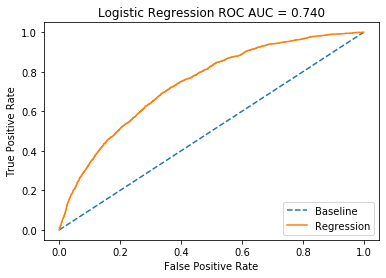

In [929]:
# ROC metric

probs = lr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Loading the validation dataset, preprocessing data using the same logic and applying the model

In [930]:
df2 = pd.read_csv("./sf-dst-scoring/test.csv", low_memory = False)

In [931]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [932]:
df2.drop('app_date', axis=1, inplace=True)
df2.education.fillna(value=df2.education.value_counts().index[0], inplace=True)

In [933]:
num_cols = ['bki_request_cnt','decline_app_cnt','age','score_bki']      # numerical values -> standartize
bin_cols = ['sex','car','car_type','foreign_passport','good_work']      # binary values -> labelEncoder
cat_cols = ['home_address','work_address','region_rating','sna','first_time']   # categorical values -> OneHot encoder

In [934]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df2[column] = label_encoder.fit_transform(df2[column])

In [935]:
data_category2 = pd.get_dummies(df2.education, drop_first=True)
df2.drop('education', axis=1, inplace=True)
df2 = pd.concat([df2, data_category2], axis=1)

In [936]:
df2['income_more_40k'] = df2.income.apply(lambda x: int(x > 40000))
df2.drop('income', axis=1, inplace=True)

In [937]:
# The final list of features to be used in the model

num_cols = ['bki_request_cnt','decline_app_cnt','score_bki','age']      # numerical values -> standartize
bin_cols = ['sex','car','car_type','foreign_passport','good_work','income_more_40k']
cat_cols = ['home_address','work_address','region_rating','sna','first_time']   # categorical values -> one hot encoder
edu_cols = ['GRD','SCH','PGR']
bin_cols = bin_cols + edu_cols

In [938]:
X_cat2 = OneHotEncoder(sparse = False).fit_transform(df2[cat_cols].values)
X_num2 = StandardScaler().fit_transform(df2[num_cols].values)
X2 = np.hstack([X_num2, df2[bin_cols].values, X_cat2])

In [892]:
y2_pred=lr.predict_proba(X2)[:,1]

In [893]:
y2 = pd.DataFrame({'default': y2_pred})

In [894]:
submission = pd.concat([df2.client_id, y2], axis=1 )

In [895]:
submission.to_csv("./sf-dst-scoring/submission.csv", index=False)